# Challenge Problem 1
- Identify object in picture (['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
- Architecture: Convolutional Neural Network (CNN)

## Import Libraries

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, KFold, ParameterSampler
from sklearn.metrics import confusion_matrix, classification_report

import cv2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load the Data

In [2]:
from tensorflow.keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
# Understanding the Data
print(f"Total number of training dataset: {len(X_train)}")
print(f"Shape of Train: {X_train.shape}")
print(f"Total number of test dataset: {len(X_test)}")
print(f"Shape of Test: {X_test.shape}")

unique_elements, counts_elements = np.unique(y_train, return_counts=True)

print(f"Number of classes: {len(unique_elements)}")
print("\n")

print(f'''Number of train samples by class: 
Class Labels: {unique_elements}
Number of Samples: {counts_elements}''')
print("\n")

unique_elements, counts_elements = np.unique(y_test, return_counts=True)

print(f'''Number of test samples by class: 
Class Labels: {unique_elements}
Number of Samples: {counts_elements}''')
print("\n")

Total number of training dataset: 50000
Shape of Train: (50000, 32, 32, 3)
Total number of test dataset: 10000
Shape of Test: (10000, 32, 32, 3)
Number of classes: 10


Number of train samples by class: 
Class Labels: [0 1 2 3 4 5 6 7 8 9]
Number of Samples: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


Number of test samples by class: 
Class Labels: [0 1 2 3 4 5 6 7 8 9]
Number of Samples: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]




## View Sample Image

In [4]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def show_sample_image(X_train, y_train, image_id):
    print(f"Class Label: {y_train[image_id]}")
    print(f"Label Name: {load_label_names()[y_train[image_id][0]]}")
    plt.imshow(X_train[image_id]);

Class Label: [9]
Label Name: truck


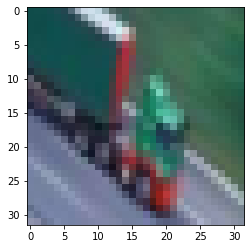

In [5]:
show_sample_image(X_train, y_train, image_id=50)

## Normalize the Data

In [6]:
# Normalize the X data
max_val = X_train.max()
X_train = X_train/max_val
X_test = X_test/max_val

# One-hot encode the output
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


## Data Augmentation

In [7]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# Prepare Iterator
it_train = datagen.flow(X_train, y_train_cat, batch_size=64)

In [8]:
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

# Prepare Iterator
it_train = datagen.flow(X_train, y_train_cat, batch_size=64)

## Define Model

In [9]:
height = X_train.shape[1]
width = X_train.shape[2]
channel = X_train.shape[3]

def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation="relu", kernel_initializer='he_uniform', padding="same", input_shape=(height, width, channel)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation="relu", kernel_initializer='he_uniform', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3,3), activation="relu", kernel_initializer='he_uniform', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation="relu", kernel_initializer='he_uniform', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3,3), activation="relu", kernel_initializer='he_uniform', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation="relu", kernel_initializer='he_uniform', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, (3,3), activation="relu", kernel_initializer='he_uniform', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation="relu", kernel_initializer='he_uniform', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(512, (3,3), activation="relu", kernel_initializer='he_uniform', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), activation="relu", kernel_initializer='he_uniform', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    #model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation="relu", kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation="relu", kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Dense(64, activation="relu", kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(32, activation="relu", kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(16, activation="relu", kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(10, activation="softmax"))
    
    # Compile Model
    #opt = SGD(lr=0.001, momentum=0.9)
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    
    return model


In [10]:
# Plot Model Diagnostic
def summary_diagnostics(history):
    # Plot Loss
    plt.figure(figsize=(12,8))
    plt.title("Cross Entropy Loss")
    plt.plot(history.history["loss"], color='blue', label='train')
    plt.plot(history.history["val_loss"], color='red', label='test')
    
    # Plot Accuracy
    plt.figure(figsize=(12,8))
    plt.title("Classification Accuracy")
    plt.plot(history.history["accuracy"], color='blue', label='train')
    plt.plot(history.history["val_accuracy"], color='orange', label='test')


## Train Model

In [11]:
# Define Model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [12]:
steps = int(X_train.shape[0]/64)

In [13]:
# Fit Model
early_stopper = EarlyStopping(patience=10, verbose=1)
reduce_on_plateau = ReduceLROnPlateau(verbose=1, patience=10, factor=0.1)

history = model.fit_generator(generator=it_train, steps_per_epoch=steps, epochs=200, validation_data=(X_test, y_test_cat), callbacks=[reduce_on_plateau]) #, callbacks=[early_stopper, reduce_on_plateau])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
781/781 [==============================] - 26s 33ms/step - loss: 2.0961 - accuracy: 0.2127 - val_loss: 1.7478 - val_accuracy: 0.2986
Epoch 2/200
781/781 [==============================] - 25s 32ms/step - loss: 1.7857 - accuracy: 0.3067 - val_loss: 1.6217 - val_accuracy: 0.3770
Epoch 3/200
781/781 [==============================] - 25s 32ms/step - loss: 1.6420 - accuracy: 0.3736 - val_loss: 1.7063 - val_accuracy: 0.4150
Epoch 4/200
781/781 [==============================] - 25s 32ms/step - loss: 1.5288 - accuracy: 0.4258 - val_loss: 1.3108 - val_accuracy: 0.5114
Epoch 5/200
781/781 [==============================] - 25s 31ms/step - loss: 1.4159 - accuracy: 0.4761 - val_loss: 1.3466 - val_accuracy: 0.5030
Epoch 6/200
781/781 [==============================] - 25s 32ms/step - loss: 1.3309 - accuracy: 0.5263 - val_loss: 1.0578 - val_accuracy: 0.6395
Epoch 7/200
781/781 [==============================] -

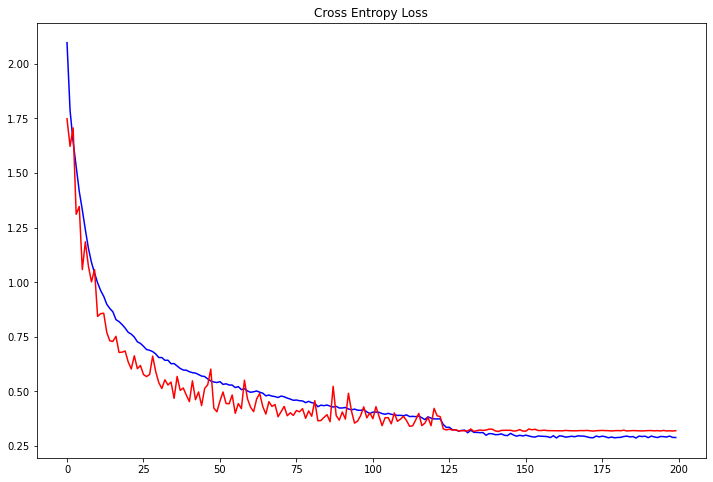

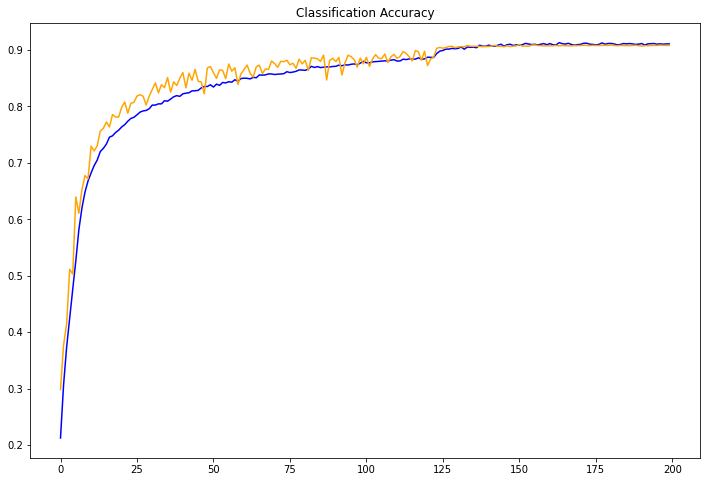

In [14]:
# Madel Diagnostics
summary_diagnostics(history)

## Model Evaluation

###### Confusion Matrix

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


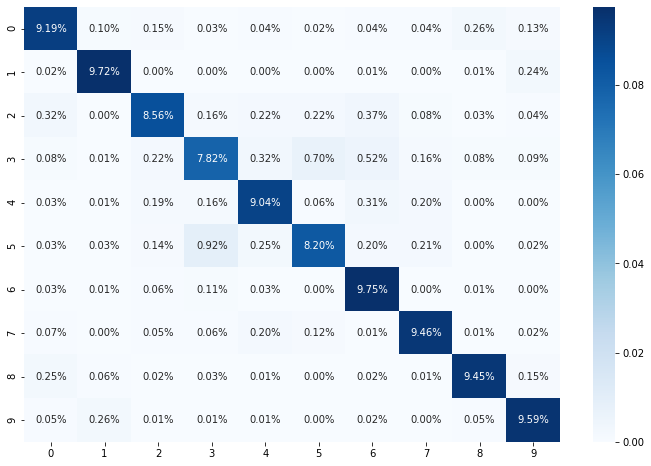

In [15]:
cf_matrix = confusion_matrix(y_test, model.predict_classes(X_test))

plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

###### Classification Report

In [16]:
print(classification_report(y_test, model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1000
           1       0.95      0.97      0.96      1000
           2       0.91      0.86      0.88      1000
           3       0.84      0.78      0.81      1000
           4       0.89      0.90      0.90      1000
           5       0.88      0.82      0.85      1000
           6       0.87      0.97      0.92      1000
           7       0.93      0.95      0.94      1000
           8       0.95      0.94      0.95      1000
           9       0.93      0.96      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



## Generate Predictions

In [17]:
# Load Test Data
test_data = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/cifar_image_flattened_pixels.csv")

# Normalize Test Data
test_data = test_data.values
test_data = test_data/test_data.max()

# Reshape test Data to required shape
test_data = test_data.reshape(test_data.shape[0], height, width, channel)


In [18]:
# Generate predictions for test data
y_predicted = model.predict(test_data)
y_predicted_labels = np.argmax(y_predicted, axis=1)

# Save Prediction Results
y_pred = pd.DataFrame(data=y_predicted_labels, columns=["predictions"])
y_pred.to_csv("CNN_prediction_results.csv", index=False)